# Correlation Analysis: News Sentiment and Stock Movement (Task 3)

## Notebook Overview

This notebook focuses on **Task 3: Correlation between news and stock movement**. It covers the integration of financial news sentiment with stock price data, performs sentiment analysis on headlines, and calculates the correlation between news sentiment and daily stock returns.

### Objectives:
* Align news and stock data by date.
* Conduct sentiment analysis on news headlines.
* Calculate daily stock returns.
* Determine the correlation between news sentiment and stock movements.

## 1. Setup and Data Loading

This section prepares the environment and loads the necessary datasets for correlation analysis.

### 1.1 Import Libraries

We'll import `pandas` for data manipulation, `yfinance` to potentially re-load stock data, and `nltk`/`textblob` for sentiment analysis.

In [2]:
# Code Cell: Import Libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download NLTK data (run only if not already downloaded)
# try:
#     nltk.data.find('sentiment/vader_lexicon')
# except nltk.downloader.DownloadError:
#     nltk.download('vader_lexicon')

# Configure plot styles
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

print("Libraries imported and NLTK data checked.")

Libraries imported and NLTK data checked.


### 1.2 Load Stock and News Data

We load the processed stock data (which ideally includes 'Daily_Return' from Task 2) and the raw financial news dataset. We'll re-load stock data directly here for notebook self-containment, ensuring columns are flattened.

In [11]:
# Code Cell: Load News Data
news_data_path = '../data/raw_analyst_ratings.csv' # Adjust path as needed based on your file location

try:
    news_df = pd.read_csv(news_data_path)
    print(f"\nLoaded news data from {news_data_path}")
except FileNotFoundError:
    print(f"Error: News data file not found at {news_data_path}. Please create or adjust path.")
    # Create an empty DataFrame with expected columns for graceful handling downstream
    news_df = pd.DataFrame(columns=['headline', 'date', 'stock'])
except Exception as e:
    print(f"An unexpected error occurred while loading news data: {e}")
    news_df = pd.DataFrame(columns=['headline', 'date', 'stock'])


# Convert 'date' column to datetime and normalize
if 'date' in news_df.columns:
    print("\n--- Attempting Date Column Conversion ---")
    print(f"Original 'date' column dtype: {news_df['date'].dtype}")
    print(f"Sample raw date values: {news_df['date'].head(5).tolist()}") # Inspect this output carefully!

    # Convert to datetime, coercing errors to NaT (Not a Time)
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

    # Drop rows where date could not be parsed
    initial_news_rows = news_df.shape[0]
    news_df.dropna(subset=['date'], inplace=True)
    rows_after_date_dropna = news_df.shape[0]
    if initial_news_rows != rows_after_date_dropna:
        print(f"Dropped {initial_news_rows - rows_after_date_dropna} rows from news data due to unparseable dates.")

    # Handle timezone as specified in the challenge: "UTC-4 timezone" 
    # If the date strings already have timezone info, tz_localize will warn or fail,
    # so we first check if timezone info is present.
    if news_df['date'].dt.tz is None:
        # If no timezone info, assume it's in America/New_York (UTC-4/EST/EDT) 
        news_df['date'] = news_df['date'].dt.tz_localize('America/New_York', ambiguous='infer', nonexistent='NaT')
        print("Date column localized to 'America/New_York' timezone.")
    else:
        print("Date column already contains timezone information.")

    # Convert all dates to UTC for consistency in analysis
    news_df['date'] = news_df['date'].dt.tz_convert('UTC')
    print("Date column converted to UTC.")


    # Create a 'date_only' column for merging, normalized to the start of the day in UTC
    news_df['date_only'] = news_df['date'].dt.normalize()
    print("News 'date' column processed and 'date_only' created.")
else:
    print("Warning: 'date' column not found in news_df. Cannot process dates.")

print("\nNews Data Head (after date processing):")
print(news_df[['headline', 'date', 'date_only']].head())


Loaded news data from ../data/raw_analyst_ratings.csv

--- Attempting Date Column Conversion ---
Original 'date' column dtype: object
Sample raw date values: ['2020-06-05 10:30:54-04:00', '2020-06-03 10:45:20-04:00', '2020-05-26 04:30:07-04:00', '2020-05-22 12:45:06-04:00', '2020-05-22 11:38:59-04:00']
Dropped 1351341 rows from news data due to unparseable dates.
Date column already contains timezone information.
Date column converted to UTC.
News 'date' column processed and 'date_only' created.

News Data Head (after date processing):
                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                       date                 date_only  
0 2020-06-05 14:30:54+00:00 2020-06-05 00:00:00+00:00  
1 2020-0

## 2. Sentiment Analysis

This section performs sentiment analysis on the news headlines to quantify their emotional tone. We use NLTK's VADER (Valence Aware Dictionary and sEntiment Reasoner) for its effectiveness with social media and news-like text.

In [12]:
import nltk

# Define a custom directory for NLTK data (optional, but can help if default paths have permission issues)
# If you choose a custom path, remember to add it to NLTK's data path later
# nltk.data.path.append('/path/to/your/nltk_data_directory')

print("Attempting to download 'vader_lexicon'...")
try:
    nltk.download('vader_lexicon')
    print("'vader_lexicon' downloaded successfully!")
except Exception as e:
    print(f"Error during NLTK download: {e}")
    print("Please ensure you have an active internet connection and sufficient disk space.")

print("\nAttempting to download 'punkt' (often needed for TextBlob, good to have):")
try:
    nltk.download('punkt')
    print("'punkt' downloaded successfully!")
except Exception as e:
    print(f"Error during NLTK download: {e}")
    print("Please ensure you have an active internet connection and sufficient disk space.")

# You can also list all downloaded packages to verify
# print("\nNLTK packages info:")
# nltk.download('all', download_dir='./nltk_data', quiet=True) # Downloads all to a local folder
# You might then need to add: nltk.data.path.append('./nltk_data')

Attempting to download 'vader_lexicon'...
'vader_lexicon' downloaded successfully!

Attempting to download 'punkt' (often needed for TextBlob, good to have):
'punkt' downloaded successfully!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Abeni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Abeni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


VADER sentiment scores calculated for news headlines.

News data with sentiment_score (first 5 rows):
                                            headline  sentiment_score
0            Stocks That Hit 52-Week Highs On Friday            0.000
1         Stocks That Hit 52-Week Highs On Wednesday            0.000
2                      71 Biggest Movers From Friday            0.000
3       46 Stocks Moving In Friday's Mid-Day Session            0.000
4  B of A Securities Maintains Neutral on Agilent...            0.296

Sentiment Score Statistics:
count    55987.000000
mean         0.066572
std          0.313522
min         -0.938200
25%          0.000000
50%          0.000000
75%          0.202300
max          0.966600
Name: sentiment_score, dtype: float64


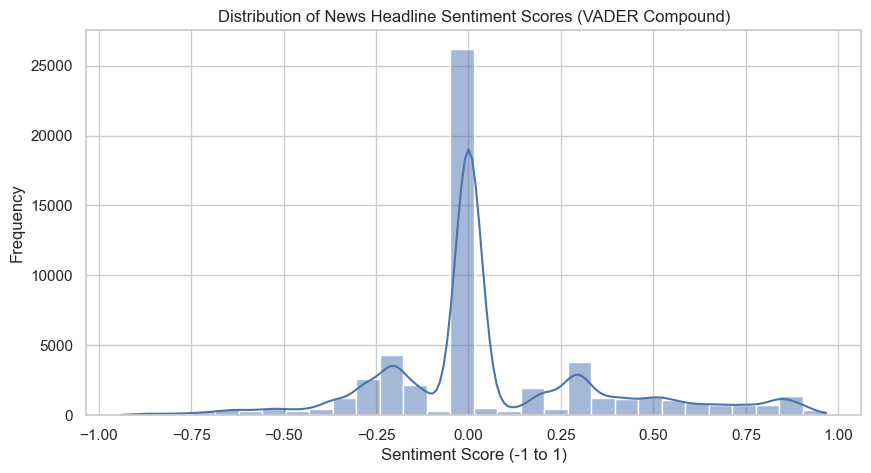

In [13]:
# Code Cell: Perform Sentiment Analysis 
if 'headline' in news_df.columns:
    analyzer = SentimentIntensityAnalyzer()

    # Function to get VADER compound sentiment score 
    def get_vader_compound_sentiment(text):
        if pd.isna(text) or text is None:
            return 0.0 # Assign neutral sentiment for missing/empty headlines
        return analyzer.polarity_scores(str(text))['compound']

    news_df['sentiment_score'] = news_df['headline'].apply(get_vader_compound_sentiment)
    print("VADER sentiment scores calculated for news headlines.")
    print("\nNews data with sentiment_score (first 5 rows):")
    print(news_df[['headline', 'sentiment_score']].head())
else:
    print("Error: 'headline' column not found in news_df. Skipping sentiment analysis.")

# Basic descriptive statistics of sentiment scores
print("\nSentiment Score Statistics:")
print(news_df['sentiment_score'].describe())

# Histogram of sentiment scores
plt.figure(figsize=(10, 5))
sns.histplot(news_df['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of News Headline Sentiment Scores (VADER Compound)')
plt.xlabel('Sentiment Score (-1 to 1)')
plt.ylabel('Frequency')
plt.show()